
# Семинар 7 (part2): Metric learning + GradCam for embeddings

В рамках данного семинара рассмотрим подробно модуль lightning.pytorch. Обучим сеть, решающую задачу metric learning на датасете СARS196, https://paperswithcode.com/sota/metric-learning-on-cars196

Данные можно найти по ссылкам:
* meta : https://drive.google.com/file/d/1PD-lbbcKSelDeAYKafe3boc5mqqEe7X7/view?usp=sharing
* data : https://drive.google.com/file/d/1l9EnYMC-xGX706SY1kN8RceMmFViASfx/view?usp=sharing

А также рассмотрим библиотеку GradCam для интерпретации работы моделей компьютерного зрения:
repo - https://github.com/jacobgil/pytorch-grad-cam

paper - https://arxiv.org/abs/1610.02391

In [ ]:
!pip install pytorch_metric_learning
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.8/127.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 70.1 MB/s eta 0:00:00


In [ ]:
 pip install opencv-python

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from PIL import Image
import cv2 as cv2
import os
import matplotlib.pyplot as plt
import random
import pandas as pd
device = 'cuda'

In [ ]:
import zipfile
import os
import scipy.io

if not os.path.exists('./devkit/') or not os.listdir('./devkit/'):
    with zipfile.ZipFile('devkit.zip', 'r') as zip_ref:
        zip_ref.extractall('.')
    print("Архив devkit.zip распакован")
else:
    print("Папка devkit уже существует")
mat = scipy.io.loadmat('./devkit/cars_train_annos.mat')
fname_to_class = {fname:cl-1 for fname, cl in zip([i[0] for i in mat['annotations'][0]['fname']],
                                                [i[0][0] for i in mat['annotations'][0]['class']])}
cars_meta = scipy.io.loadmat('./devkit/cars_meta.mat')
id_to_car = {idx: car[0] for idx, car in enumerate(cars_meta['class_names'][0])}

Папка devkit уже существует


In [ ]:
ADD_PATH = './drive/MyDrive/cars/cars_train/cars_train'

In [ ]:
import scipy.io
mat = scipy.io.loadmat('./devkit/cars_train_annos.mat')
fname_to_class = {fname:cl-1 for fname, cl in zip([i[0] for i in mat['annotations'][0]['fname']],
                                                [i[0][0] for i in mat['annotations'][0]['class']])}
cars_meta = scipy.io.loadmat('./devkit/cars_meta.mat')
id_to_car = {idx: car[0] for idx, car in enumerate(cars_meta['class_names'][0])}

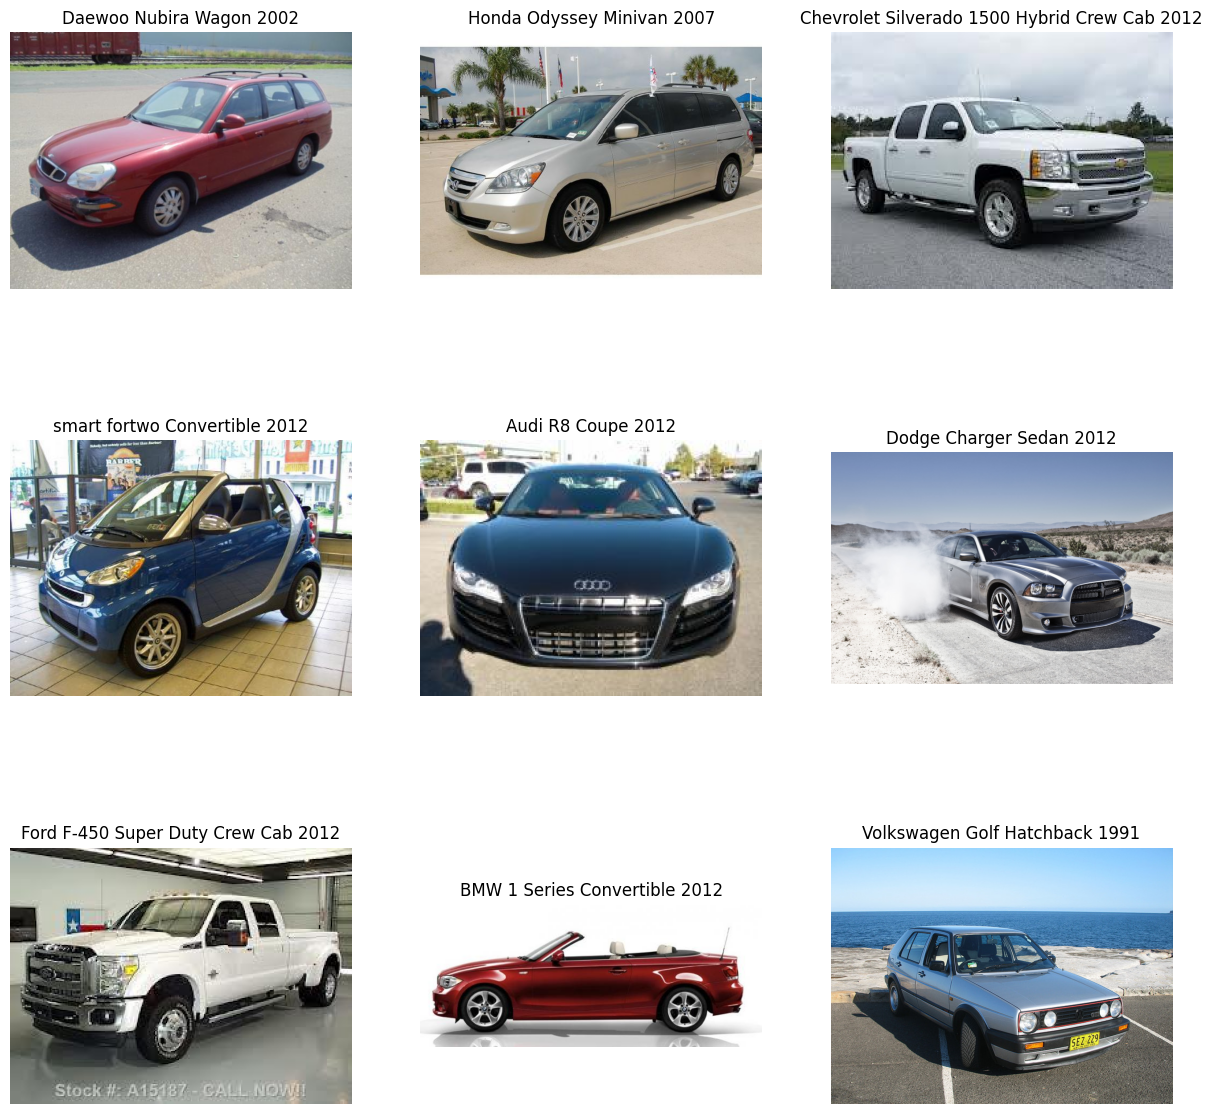

In [ ]:
num_imgs = 9
cols = 3
rows = num_imgs // cols
fig, ax = plt.subplots(rows, cols, figsize = (15, 15))
for idx, im_idx in enumerate(random.sample([i for i in range(len(fname_to_class))], num_imgs)):
    filename, cl_id = list(fname_to_class.items())[im_idx]
    temp_image = cv2.imread(os.path.join(ADD_PATH, filename))
    temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB)
    ax[idx//cols][idx%cols].imshow(temp_image)
    ax[idx//cols][idx%cols].set_title(f'{id_to_car[cl_id]}')
    ax[idx//cols][idx%cols].axis('off')

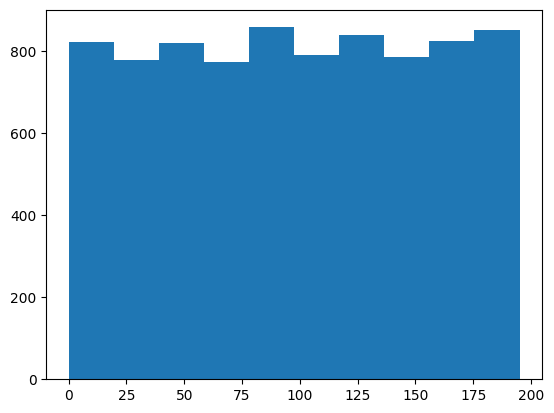

In [ ]:
plt.hist(fname_to_class.values())
plt.show()

In [ ]:
import torch
import torchvision
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

train_transforms =  torchvision.transforms.Compose([
            torchvision.transforms.ToPILImage(),
            torchvision.transforms.Resize(
                size=(224, 224)
            ),
            torchvision.transforms.RandomCrop(224),
            torchvision.transforms.RandomHorizontalFlip(p=0.5),
            torchvision.transforms.RandomRotation(10),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
            ])
val_transforms = torchvision.transforms.Compose([
            torchvision.transforms.ToPILImage(),
            torchvision.transforms.Resize(
                size=(224, 224)
            ),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
            ])

class CropClassifDataset(torch.utils.data.Dataset):
    def __init__(self, cars_items, transforms):
        self.cars = cars_items
        self.transforms = transforms

    def __len__(self):
        return len(self.cars)

    def __getitem__(self, idx):
        filename, cl_id = self.cars[idx]
        image = cv2.imread(os.path.join(ADD_PATH, filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transforms:
            image = self.transforms(image)
        sample = {'image': image, 'label': cl_id}
        return sample

In [ ]:
items = list(fname_to_class.items())
random.shuffle(items)
train_items = items[:int(len(items) * 0.8)]
val_items = items[int(len(items) * 0.8):]

train_dataset = CropClassifDataset(train_items, train_transforms)
val_dataset = CropClassifDataset(val_items, val_transforms)


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, collate_fn=None, pin_memory=True, drop_last = True)
valid_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, collate_fn=None, pin_memory=True)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# Triplet Loss

In [ ]:
pip install lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 828.5/828.5 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 70.1 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from pytorch_metric_learning import losses, miners, distances, reducers
import lightning.pytorch as pl
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import LearningRateMonitor
import torch.nn.functional as F

class CarEmbedder(pl.LightningModule):
    def __init__(self, learning_rate=3e-4, emb_size=512):
        super().__init__()
        self.learning_rate = learning_rate
        self.emb_size = emb_size

        self.model = models.efficientnet_b0(pretrained=True)

        in_features = self.model.classifier[1].in_features
        self.model.classifier = nn.Sequential(
            nn.Linear(in_features, emb_size),
            nn.BatchNorm1d(emb_size)
        )

        self.triplet_loss = losses.TripletMarginLoss(margin=0.2)
        self.miner = miners.TripletMarginMiner(margin=0.2, type_of_triplets="semihard")

        self.save_hyperparameters()

    def training_step(self, batch, batch_idx):
        images, labels = batch['image'], batch['label']
        embeddings = self.model(images)

        hard_triplets = self.miner(embeddings, labels)
        triplet_loss = self.triplet_loss(embeddings, labels, hard_triplets)

        self.log("train_loss", triplet_loss, prog_bar=True)
        return triplet_loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch['image'], batch['label']
        embeddings = self.model(images)
        triplet_loss = self.triplet_loss(embeddings, labels)

        self.log("validation_loss", triplet_loss, prog_bar=True)
        return triplet_loss

    def forward(self, images):
        return self.model(images)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
        return [optimizer], [scheduler]

In [ ]:
pl_model = CarEmbedder(learning_rate=3e-4, emb_size=512)
checkpoint_callback = ModelCheckpoint(monitor='validation_loss', mode='min', save_top_k=3)
early_stopping = EarlyStopping(monitor="validation_loss", mode="min", patience=2)
lr_monitor = LearningRateMonitor(logging_interval='step')

trainer = pl.Trainer(
    max_epochs=40,
    accelerator=device if torch.cuda.is_available() else "cpu",
    devices=1,
    callbacks=[checkpoint_callback, early_stopping, lr_monitor])

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False

In [ ]:
trainer.fit(model=pl_model, train_dataloaders=train_loader,
            val_dataloaders=valid_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name         | Type               | Params | Mode 
------------------------------------------------------------
0 | model        | EfficientNet       | 4.7 M  | train
1 | triplet_loss | TripletMarginLoss  | 0      | train
2 | miner        | TripletMarginMiner | 0      | train
------------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.658    Total estimated model params size (MB)
342       Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name         | Type               | Params | Mode 
------------------------------------------------------------
0 | model        | EfficientNet       | 4.7 M  | train
1 | triplet_loss | TripletMarginLoss  | 0      | train
2 | miner        | TripletMarginMiner | 0      | trai

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
torch.save(pl_model.state_dict(), 'car_embedder_model.pth')
torch.save(pl_model, 'car_embedder_full.pth')

print("Модель сохранена!")


Модель сохранена!


In [ ]:
trainer.validate(model=pl_model, dataloaders=valid_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      validation_loss      │    0.22633658349514008    │
└───────────────────────────┴───────────────────────────┘

[{'validation_loss': 0.22633658349514008}]

In [ ]:
import tqdm
import numpy as np
pl_model.eval()
pl_model.to(device)
np.float32

numpy.float32

In [ ]:
def get_embeds(model, loader):
    embeddings = np.empty((1,512))
    labels = np.empty((1))
    for batch in tqdm.tqdm_notebook(loader):
        imgs = batch['image']
        label = batch['label']
        with torch.no_grad():
            preds = model(imgs.to(device))
        embeddings = np.concatenate([embeddings, preds.cpu().numpy()])
        labels = np.concatenate([labels, label.numpy()])
    return embeddings[1:].astype(np.float32), labels[1:]

In [ ]:
train_emb, train_labels = get_embeds(pl_model, train_loader)
val_emb, val_labels = get_embeds(pl_model, valid_loader)

/tmp/ipython-input-3342089651.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm.tqdm_notebook(loader):


  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

In [ ]:
train_emb.shape

(6464, 512)

In [ ]:
import faiss
index = faiss.IndexFlatL2(512)
print(index.is_trained)
index.add(train_emb)
print(index.ntotal)

k = 4
D, I = index.search(train_emb[:5], k)
print(I)
print(D)
D, I = index.search(val_emb, k)
print(I[:5])
print(I[-5:])

True
6464
[[   0 5968 4649 1843]
 [   1 3420 1707 5598]
 [   2  226  471 5708]
 [   3 3232  803 6034]
 [   4 2060 3842  126]]
[[ 0.        37.527115  62.789055  67.85463  ]
 [ 0.        29.582647  41.60801   48.063873 ]
 [ 0.        10.3749485 10.540379  15.849119 ]
 [ 0.        18.047318  37.73849   40.71695  ]
 [ 0.        29.931288  40.046425  40.15322  ]]
[[ 207 1799  706 1791]
 [1408 2245  170 3224]
 [1179 5473 1217 4354]
 [1340 4522  332 3629]
 [1946 3697  967 2481]]
[[2407 6333   16 1660]
 [1485 3286  278 1212]
 [2858 2052  931 4317]
 [4019 2255 5918 3884]
 [3213 2231 5447 5415]]


In [ ]:
Distances, Indexes = index.search(val_emb, 1)

In [ ]:
Indexes

array([[ 207],
       [1408],
       [1179],
       ...,
       [2858],
       [4019],
       [3213]])

# GradCam with embeds

=== МЕТРИКИ КАЧЕСТВА ===
Precision@1: 0.2609 | Recall@1: 0.0084
Precision@2: 0.3941 | Recall@2: 0.0158
Precision@4: 0.5273 | Recall@4: 0.0293
Precision@8: 0.5273 | Recall@8: 0.0293
Precision@10: 0.5273 | Recall@10: 0.0293
mAP@4: 0.3560

=== GRADCAM АНАЛИЗ ОШИБОК ===
Всего ошибок: 1204 из 1629 запросов
Показываем топ 5 ошибок:


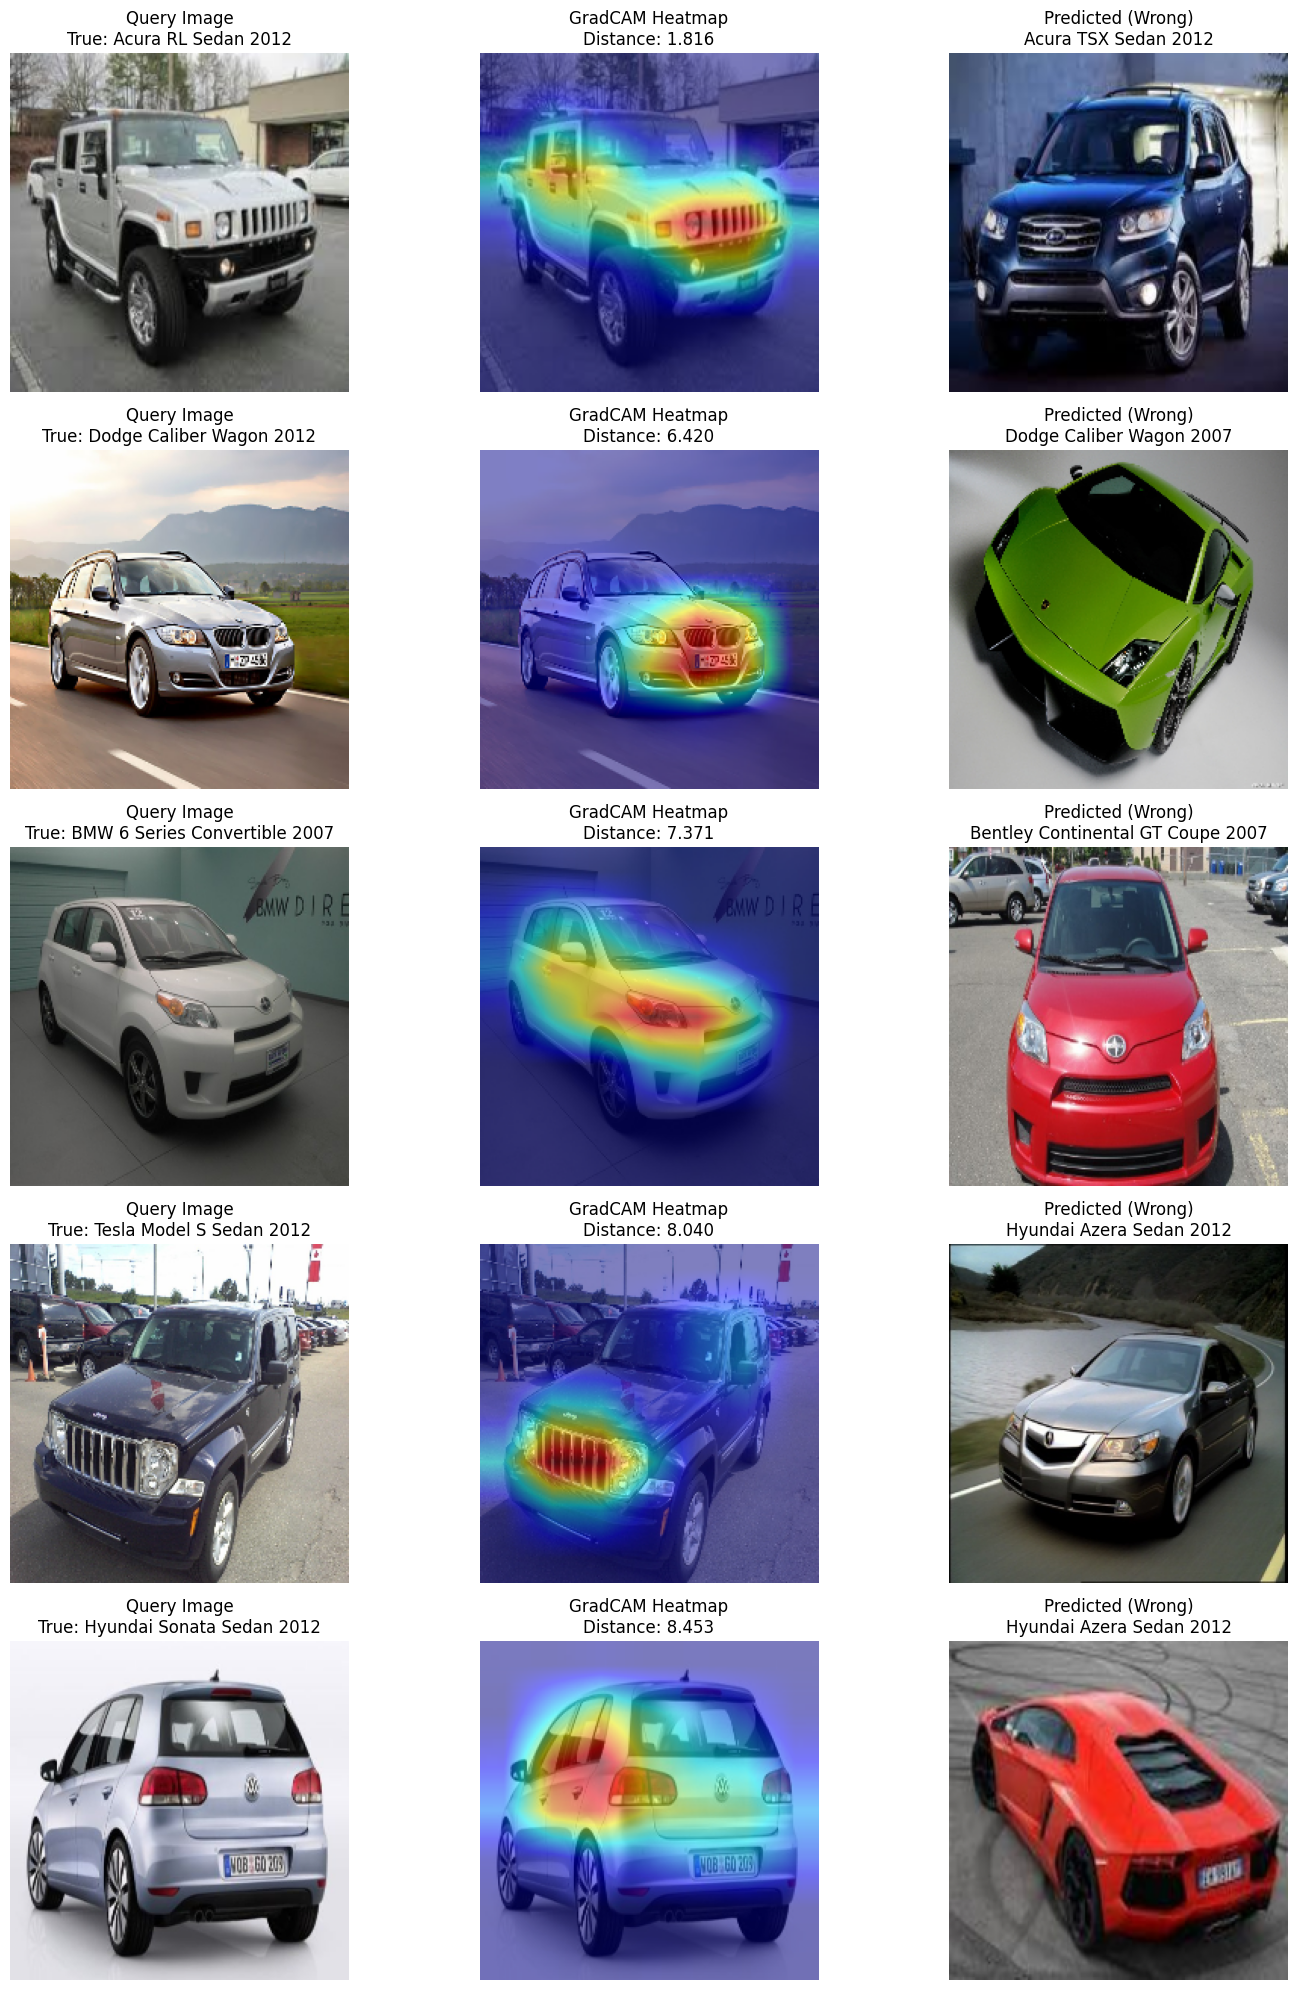

In [ ]:
def precision_at_k(neighbors_idx, query_labels, gallery_labels, k=1):
    correct_predictions = 0

    for i in range(len(query_labels)):
        top_k_neighbors = neighbors_idx[i, :k]
        found_correct = any(gallery_labels[top_k_neighbors] == query_labels[i])
        correct_predictions += found_correct

    return correct_predictions / len(query_labels)

def recall_at_k(neighbors_idx, query_labels, gallery_labels, k=1):
    total_recall = 0

    for i in range(len(query_labels)):
        query_label = query_labels[i]
        total_relevant = np.sum(gallery_labels == query_label) - 1

        if total_relevant > 0:
            top_k_neighbors = neighbors_idx[i, :k]
            found_relevant = np.sum(gallery_labels[top_k_neighbors] == query_label)
            total_recall += found_relevant / total_relevant

    return total_recall / len(query_labels)

def average_precision_for_query(relevance_scores):
    if not any(relevance_scores):
        return 0.0

    precision_scores = []
    correct_count = 0

    for i, is_relevant in enumerate(relevance_scores, 1):
        if is_relevant:
            correct_count += 1
            precision_scores.append(correct_count / i)

    return np.mean(precision_scores)

def mean_average_precision(neighbors_idx, query_labels, gallery_labels, k=4):
    average_precisions = []

    for i in range(len(query_labels)):
        top_k_neighbors = neighbors_idx[i, :k]
        relevance = (gallery_labels[top_k_neighbors] == query_labels[i])
        ap = average_precision_for_query(relevance)
        average_precisions.append(ap)

    return np.mean(average_precisions)

query_y = val_labels
gallery_y = train_labels

for topk in [1, 2, 4, 8, 10]:
    print(f"Precision@{topk}: {precision_at_k(I, query_y, gallery_y, topk):.4f} | "
          f"Recall@{topk}: {recall_at_k(I, query_y, gallery_y, topk):.4f}")
print(f"mAP@4: {mean_average_precision(I, query_y, gallery_y, k=4):.4f}")

def analyze_errors_with_gradcam(model, val_dataset, I, query_y, gallery_y, num_examples=5):
    model.eval()
    model.to(device)

    target_layers = [model.model.features[-1]]
    cam = GradCAM(model=model.model, target_layers=target_layers)

    errors = []
    for i in range(len(query_y)):
        predicted_label = gallery_y[I[i][0]]
        true_label = query_y[i]

        if predicted_label != true_label:
            errors.append({
                'val_idx': i,
                'true_label': true_label,
                'pred_label': predicted_label,
                'distance': D[i][0],
                'filename': list(fname_to_class.keys())[i]
            })

    errors.sort(key=lambda x: x['distance'])

    print(f"Всего ошибок: {len(errors)} из {len(query_y)} запросов")
    print(f"Показываем топ {min(num_examples, len(errors))} ошибок:")

    fig, axes = plt.subplots(min(num_examples, len(errors)), 3,
                            figsize=(15, 4*min(num_examples, len(errors))))

    if min(num_examples, len(errors)) == 1:
        axes = [axes]

    for idx, error in enumerate(errors[:num_examples]):

        filename = error['filename']
        full_path = os.path.join(ADD_PATH, filename)

        orig_image = cv2.imread(full_path)
        orig_image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)
        orig_image = cv2.resize(orig_image, (224, 224))

        image_tensor = val_transforms(orig_image).unsqueeze(0).to(device)

        grayscale_cam = cam(input_tensor=image_tensor)
        grayscale_cam = grayscale_cam[0, :]

        axes[idx][0].imshow(orig_image)
        axes[idx][0].set_title(f'Query Image\nTrue: {id_to_car[error["true_label"]]}')
        axes[idx][0].axis('off')

        cam_image = show_cam_on_image(orig_image.astype(np.float32)/255.0, grayscale_cam, use_rgb=True)
        axes[idx][1].imshow(cam_image)
        axes[idx][1].set_title(f'GradCAM Heatmap\nDistance: {error["distance"]:.3f}')
        axes[idx][1].axis('off')

        pred_filename = list(fname_to_class.keys())[I[error['val_idx']][0]]
        pred_full_path = os.path.join(ADD_PATH, pred_filename)
        pred_image = cv2.imread(pred_full_path)
        pred_image = cv2.cvtColor(pred_image, cv2.COLOR_BGR2RGB)
        pred_image = cv2.resize(pred_image, (224, 224))

        axes[idx][2].imshow(pred_image)
        axes[idx][2].set_title(f'Predicted (Wrong)\n{id_to_car[error["pred_label"]]}')
        axes[idx][2].axis('off')

    plt.tight_layout()
    plt.show()

    return errors
def analyze_class_performance(I, query_y, gallery_y, class_id, top_k=5):
    class_indices = np.where(query_y == class_id)[0]

    if len(class_indices) == 0:
        print(f"Класс {class_id} не найден в query")
        return

    class_correct = 0
    class_errors = []

    for idx in class_indices:
        predicted_label = gallery_y[I[idx][0]]
        if predicted_label == class_id:
            class_correct += 1
        else:
            class_errors.append({
                'val_idx': idx,
                'pred_label': predicted_label,
                'distance': D[idx][0]
            })

    accuracy = class_correct / len(class_indices)
    print(f"\n=== АНАЛИЗ КЛАССА {class_id}: {id_to_car[class_id]} ===")
    print(f"Точность: {accuracy:.4f} ({class_correct}/{len(class_indices)})")
    print(f"Ошибок: {len(class_errors)}")

    if class_errors:
        class_errors.sort(key=lambda x: x['distance'])
        print("Топ ошибки (с какими классами путает):")
        error_classes = Counter([error['pred_label'] for error in class_errors])
        for pred_class, count in error_classes.most_common(5):
            print(f"  - {id_to_car[pred_class]}: {count} ошибок")

errors = analyze_errors_with_gradcam(pl_model, val_dataset, I, query_y, gallery_y, num_examples=5)


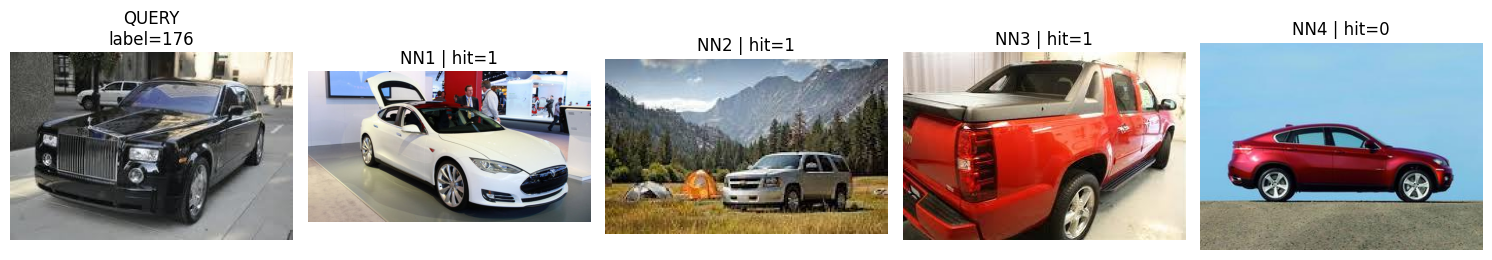

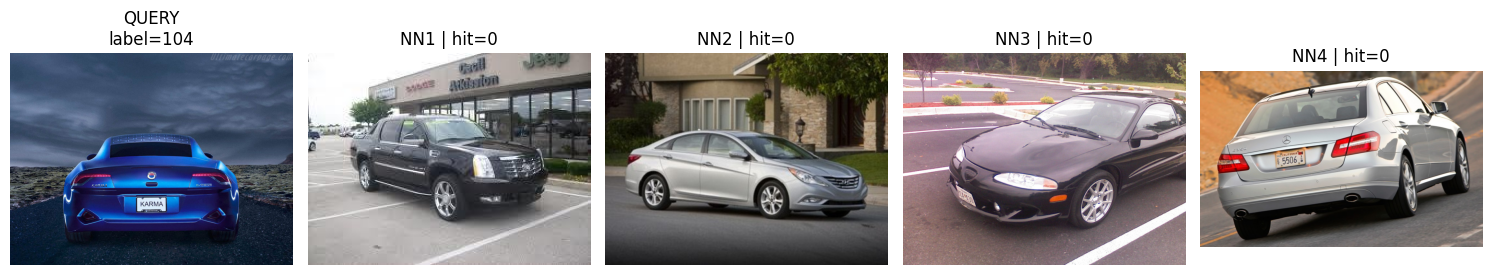

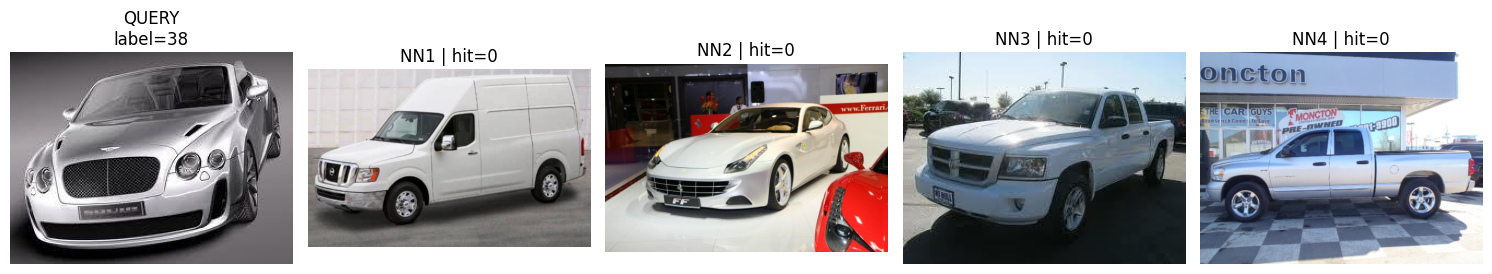

In [ ]:

train_names = [name for name,_ in train_loader.dataset.cars]
val_names   = [name for name,_ in valid_loader.dataset.cars]

def show_retrieval(q_idx, topk=5):
    q_name = val_names[q_idx]
    q_path = os.path.join(ADD_PATH, q_name)
    nn_idx = I[q_idx, :topk]
    nn_paths = [os.path.join(ADD_PATH, train_names[j]) for j in nn_idx]

    plt.figure(figsize=(3*(topk+1), 4))
    plt.subplot(1, topk+1, 1)
    plt.imshow(Image.open(q_path).convert("RGB"))
    plt.title(f"QUERY\nlabel={int(query_y[q_idx])}")
    plt.axis("off")
    for i, (p, j) in enumerate(zip(nn_paths, nn_idx), start=2):
        plt.subplot(1, topk+1, i)
        plt.imshow(Image.open(p).convert("RGB"))
        hit = int(gallery_y[j] == query_y[q_idx])
        plt.title(f"NN{i-1} | hit={hit}")
        plt.axis("off")
    plt.tight_layout(); plt.show()

for q in [0, 5, 10]:
    show_retrieval(q, topk=5)

In [ ]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 79.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=3a6a79559b04ae14bca540dc94363466f66d086940108ff25e2ffb0d4f8419db
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam
